In [1]:
import mitiq

mitiq.SUPPORTED_PROGRAM_TYPES.keys()

dict_keys(['cirq', 'pyquil', 'qiskit', 'braket', 'pennylane'])

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors.standard_errors import (
    depolarizing_error,
    amplitude_damping_error
)

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory, PolyFactory, ExpFactory, AdaExpFactory, AdaptiveFactory, LinearFactory

In [3]:
phi1=Parameter('phi1')
#phi2 = Parameter('phi2')

def Hartree_Fock(qc):
    qc.x(0)
    qc.x(1)
    qc.x(4)
    qc.x(5)
    return qc

def first_excitation_circ(qc,i,k,theta):
    qc.cx(k,i)
    # controlled ry
    qc.ry(theta, k)
    qc.cx(i,k)
    qc.ry(-theta, k)
    qc.cx(i,k)

    qc.cx(k,i)

    return qc

def double_excitation_circ(qc,i,j,k,l,theta):
    qc.cx(l,k)
    qc.cx(j,i)
    qc.cx(l,j)
    # 3 controlled ry
    qc.ry(theta/4, l)
    qc.cx(k,l,ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(i,l, ctrl_state='0')
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(j,l)
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(i,l, ctrl_state='0')
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(j,l)

    qc.cx(l,j)
    qc.cx(j,i)
    qc.cx(l,k)

    return qc

#list_T2 =[((1, 5), (2, 6)),((0,6),(3,7))]
list_T2=[((4, 5), (6, 7)), ((0, 5), (2, 7)), ((0, 1), (2, 3)), ((1, 4), (3, 6)), ((1, 5), (2, 6)), ((1, 5), (3, 7)), ((0, 4), (2, 6)), ((0, 4), (3, 7)), ((0, 5), (3, 6)), ((1, 4), (2, 5)), ((1, 6), (2, 7)), ((1, 4), (2, 7)), ((5, 0), (6, 1)), ((5, 2), (6, 3))]

list_T1=[((0,), (2,)), ((1,), (3,)), ((4,), (6,)), ((5,), (7,))]

def create_ansatz(double_exit: list, paramaters: list, single_exit: list):

    num_qubits = 8
    qc = QuantumCircuit(num_qubits)
    Hartree_Fock(qc)
    for n in range(len(list_T2)):
        double_excitation_circ(qc, double_exit[n][0][0], double_exit[n][0][1], double_exit[n][1][0], double_exit[n][1][1], paramaters[n])
    for m in range(len(single_exit)):
        first_excitation_circ(qc, single_exit[m][0], single_exit[m][1], paramaters[m+len(list_T2)])
    return qc

C:\Users\Srushti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


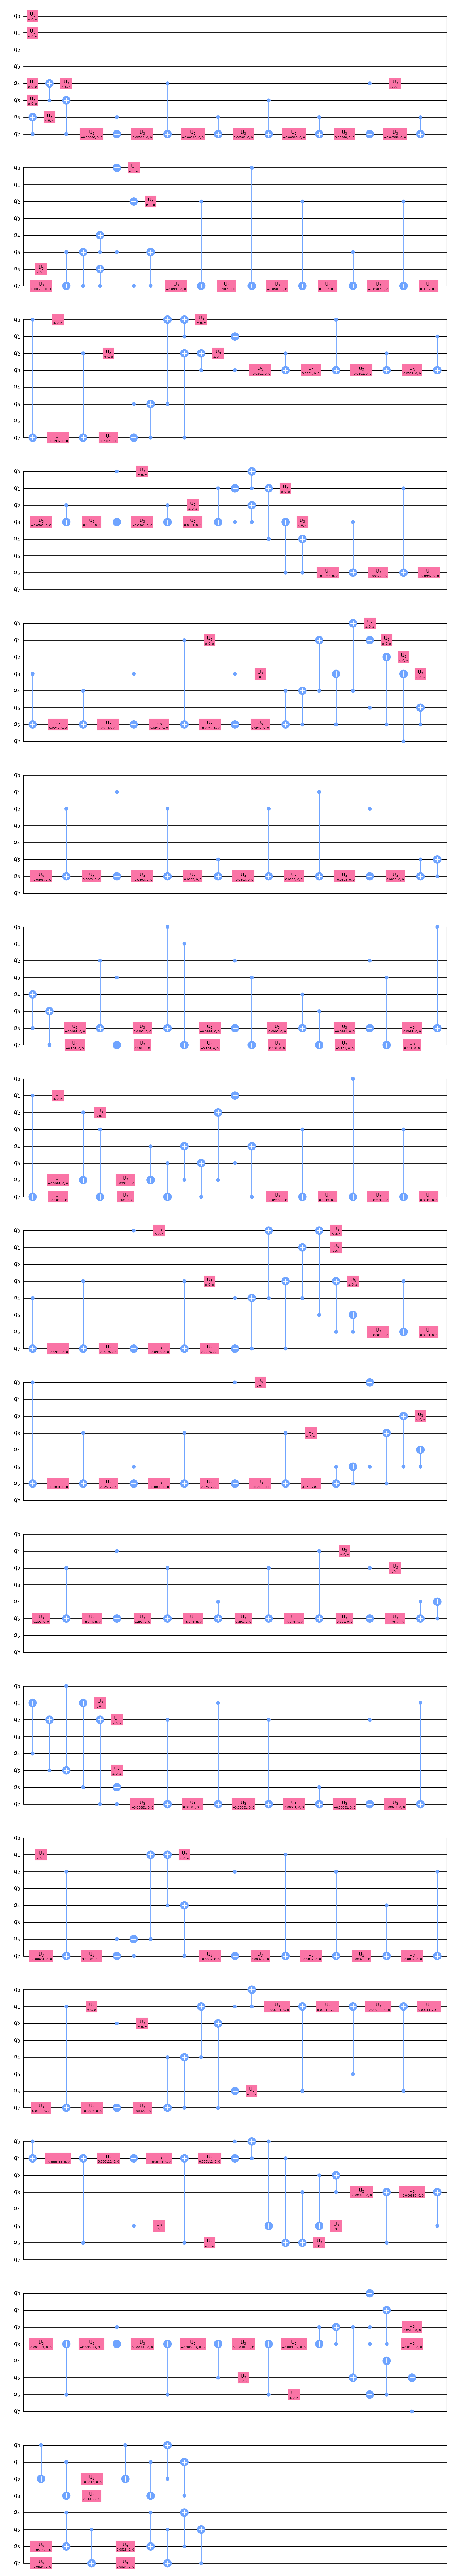

In [62]:
#initial_vector=[0.42550940939382703, 0.42550940939382703, 0.42550940939382703, 0.4255094093938269, -0.4172697807171212, -0.38841147772110596, -0.3861385489217176, -0.32503316011263744, 0.31054162330482443, -0.3663726839032295, 0.3688823395400796, 0.3105416233048244, -0.3663726839032295, 0.3688823395400796,0,0,0,0]
initial_vector = [-2.26405489e-02, -3.60603057e-01, -2.00588288e-01, -3.76954852e-01,
       -3.21022055e-01, -4.04660323e-01, -3.96588821e-01, -3.67452179e-01,
       -3.20516088e-01,  1.16379669e+00, -2.72547260e-02, -3.32962236e-01,
       -4.45871549e-04,  1.52727369e-03,  5.13352079e-02, -1.37052292e-02,
       -5.14536245e-02, -5.24445401e-02]
qc = create_ansatz(list_T2,initial_vector,list_T1)
qc = qiskit.compiler.transpile(qc, basis_gates=["u1", "u2", "u3", "cx",'cx_o0'])

qc.draw(output='mpl')

In [5]:
list_mitigated_result = []
nuclear_repulsion_energy = 0.76436708244
qubit_op = SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIIZZ', 'IIIIYZYI', 'IIIIYZYZ', 'IIIIXZXI', 'IIIIXZXZ', 'IIIIIZII', 'IIIIIZIZ', 'IIIIZIII', 'IIIIZIIZ', 'IIIZIIII', 'IIIZIIIZ', 'IYZYIIII', 'IYZYIIIZ', 'IXZXIIII', 'IXZXIIIZ', 'IIZIIIII', 'IIZIIIIZ', 'YZYIIIII', 'YZYIIIIZ', 'XZXIIIII', 'XZXIIIIZ', 'IZIIIIII', 'IZIIIIIZ', 'ZIIIIIII', 'ZIIIIIIZ', 'IIIIIYZY', 'IIIIIYIY', 'IIIIIXZX', 'IIIIIXIX', 'IIIIYYYY', 'IIIIXXYY', 'IIIIYXXY', 'IIIIXYYX', 'IIIIYYXX', 'IIIIXXXX', 'IIYYIIYY', 'IIXXIIYY', 'IIYYIIXX', 'IIXXIIXX', 'YZZYIIYY', 'XZZXIIYY', 'YZZYIIXX', 'XZZXIIXX', 'IYYIIIYY', 'IXXIIIYY', 'IYYIIIXX', 'IXXIIIXX', 'YYIIIIYY', 'XXIIIIYY', 'YYIIIIXX', 'XXIIIIXX', 'IIIIZYZY', 'IIIIZXZX', 'IIIZIYZY', 'IIIZIXZX', 'IYZYIYZY', 'IXZXIYZY', 'IYZYIXZX', 'IXZXIXZX', 'IIZIIYZY', 'IIZIIXZX', 'YZYIIYZY', 'XZXIIYZY', 'YZYIIXZX', 'XZXIIXZX', 'IZIIIYZY', 'IZIIIXZX', 'ZIIIIYZY', 'ZIIIIXZX', 'IIYYYZZY', 'IIXXYZZY', 'IIYYXZZX', 'IIXXXZZX', 'YZZYYZZY', 'XZZXYZZY', 'YZZYXZZX', 'XZZXXZZX', 'IYYIYZZY', 'IXXIYZZY', 'IYYIXZZX', 'IXXIXZZX', 'YYIIYZZY', 'XXIIYZZY', 'YYIIXZZX', 'XXIIXZZX', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IYZYIIZI', 'IXZXIIZI', 'IIZIIIZI', 'YZYIIIZI', 'XZXIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIYIYI', 'IIIIXIXI', 'IIYYIYYI', 'IIXXIYYI', 'IIYYIXXI', 'IIXXIXXI', 'YZZYIYYI', 'XZZXIYYI', 'YZZYIXXI', 'XZZXIXXI', 'IYYIIYYI', 'IXXIIYYI', 'IYYIIXXI', 'IXXIIXXI', 'YYIIIYYI', 'XXIIIYYI', 'YYIIIXXI', 'XXIIIXXI', 'IIIZYZYI', 'IIIZXZXI', 'IYZYYZYI', 'IXZXYZYI', 'IYZYXZXI', 'IXZXXZXI', 'IIZIYZYI', 'IIZIXZXI', 'YZYIYZYI', 'XZXIYZYI', 'YZYIXZXI', 'XZXIXZXI', 'IZIIYZYI', 'IZIIXZXI', 'ZIIIYZYI', 'ZIIIXZXI', 'IIIIZZII', 'IIIZIZII', 'IYZYIZII', 'IXZXIZII', 'IIZIIZII', 'YZYIIZII', 'XZXIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIYYYYII', 'IIXXYYII', 'IIYYXXII', 'IIXXXXII', 'YZZYYYII', 'XZZXYYII', 'YZZYXXII', 'XZZXXXII', 'IYYIYYII', 'IXXIYYII', 'IYYIXXII', 'IXXIXXII', 'YYIIYYII', 'XXIIYYII', 'YYIIXXII', 'XXIIXXII', 'IIIZZIII', 'IYZYZIII', 'IXZXZIII', 'IIZIZIII', 'YZYIZIII', 'XZXIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'YZYZIIII', 'XZXZIIII', 'IZIZIIII', 'ZIIZIIII', 'IYIYIIII', 'IXIXIIII', 'YYYYIIII', 'XXYYIIII', 'YXXYIIII', 'XYYXIIII', 'YYXXIIII', 'XXXXIIII', 'ZYZYIIII', 'ZXZXIIII', 'IZZIIIII', 'ZIZIIIII', 'YIYIIIII', 'XIXIIIII', 'ZZIIIIII'],
              coeffs=[-1.85502904e+00+0.j,  4.81583054e-02+0.j,  4.27360355e-02+0.j,
  2.57891581e-02+0.j,  2.04558562e-03+0.j, -6.27464680e-03+0.j,
  2.04558562e-03+0.j, -6.27464680e-03+0.j,  3.64529858e-02+0.j,
  3.30007159e-02+0.j,  3.06300748e-02+0.j,  3.86135390e-02+0.j,
  4.81583054e-02+0.j,  7.31661755e-02+0.j,  1.97123182e-03+0.j,
  8.76339225e-03+0.j,  1.97123182e-03+0.j,  8.76339225e-03+0.j,
  4.27360355e-02+0.j,  7.10045261e-02+0.j,  2.04558562e-03+0.j,
 -9.00548050e-03+0.j,  2.04558562e-03+0.j, -9.00548050e-03+0.j,
  3.64529858e-02+0.j,  7.12657357e-02+0.j,  3.06300748e-02+0.j,
  7.40674025e-02+0.j,  1.97123182e-03+0.j,  8.23208993e-03+0.j,
  1.97123182e-03+0.j,  8.23208993e-03+0.j, -1.10132664e-02+0.j,
 -7.20326168e-03+0.j, -3.81000468e-03+0.j, -3.81000468e-03+0.j,
 -7.20326168e-03+0.j, -1.10132664e-02+0.j,  4.52153680e-02+0.j,
  4.52153680e-02+0.j,  4.52153680e-02+0.j,  4.52153680e-02+0.j,
  2.73083370e-03+0.j,  2.73083370e-03+0.j,  2.73083370e-03+0.j,
  2.73083370e-03+0.j,  9.92105488e-03+0.j,  9.92105488e-03+0.j,
  9.92105488e-03+0.j,  9.92105488e-03+0.j, -4.56970944e-02+0.j,
 -4.56970944e-02+0.j, -4.56970944e-02+0.j, -4.56970944e-02+0.j,
  6.26587905e-03+0.j,  6.26587905e-03+0.j,  8.76339225e-03+0.j,
  8.76339225e-03+0.j,  3.82650198e-02+0.j,  3.82650198e-02+0.j,
  3.82650198e-02+0.j,  3.82650198e-02+0.j, -1.68896495e-03+0.j,
 -1.68896495e-03+0.j, -3.84938327e-02+0.j, -3.84938327e-02+0.j,
 -3.84938327e-02+0.j, -3.84938327e-02+0.j, -1.91756644e-03+0.j,
 -1.91756644e-03+0.j,  8.98699815e-03+0.j,  8.98699815e-03+0.j,
  2.73083370e-03+0.j,  2.73083370e-03+0.j,  2.73083370e-03+0.j,
  2.73083370e-03+0.j,  3.54538635e-02+0.j,  3.54538635e-02+0.j,
  3.54538635e-02+0.j,  3.54538635e-02+0.j, -3.46838280e-02+0.j,
 -3.46838280e-02+0.j, -3.46838280e-02+0.j, -3.46838280e-02+0.j,
 -2.72111910e-03+0.j, -2.72111910e-03+0.j, -2.72111910e-03+0.j,
 -2.72111910e-03+0.j,  3.45690108e-02+0.j,  3.31222731e-02+0.j,
  7.10045261e-02+0.j, -1.68896495e-03+0.j, -1.68896495e-03+0.j,
  7.17102376e-02+0.j,  1.49535906e-03+0.j,  1.49535906e-03+0.j,
  7.20235096e-02+0.j,  7.18631896e-02+0.j, -8.32688202e-03+0.j,
 -8.32688202e-03+0.j,  9.92105488e-03+0.j,  9.92105488e-03+0.j,
  9.92105488e-03+0.j,  9.92105488e-03+0.j, -3.46838280e-02+0.j,
 -3.46838280e-02+0.j, -3.46838280e-02+0.j, -3.46838280e-02+0.j,
  3.74544987e-02+0.j,  3.74544987e-02+0.j,  3.74544987e-02+0.j,
  3.74544987e-02+0.j, -1.00696391e-02+0.j, -1.00696391e-02+0.j,
 -1.00696391e-02+0.j, -1.00696391e-02+0.j, -9.00548050e-03+0.j,
 -9.00548050e-03+0.j, -3.84938327e-02+0.j, -3.84938327e-02+0.j,
 -3.84938327e-02+0.j, -3.84938327e-02+0.j,  1.49535906e-03+0.j,
  1.49535906e-03+0.j,  3.87409165e-02+0.j,  3.87409165e-02+0.j,
  3.87409165e-02+0.j,  3.87409165e-02+0.j,  1.74275708e-03+0.j,
  1.74275708e-03+0.j, -9.24626051e-03+0.j, -9.24626051e-03+0.j,
  2.59279774e-02+0.j,  7.12657357e-02+0.j, -1.91756644e-03+0.j,
 -1.91756644e-03+0.j,  7.20235096e-02+0.j,  1.74275708e-03+0.j,
  1.74275708e-03+0.j,  7.23838652e-02+0.j,  7.21433666e-02+0.j,
 -4.56970944e-02+0.j, -4.56970944e-02+0.j, -4.56970944e-02+0.j,
 -4.56970944e-02+0.j, -2.72111910e-03+0.j, -2.72111910e-03+0.j,
 -2.72111910e-03+0.j, -2.72111910e-03+0.j, -1.00696391e-02+0.j,
 -1.00696391e-02+0.j, -1.00696391e-02+0.j, -1.00696391e-02+0.j,
  4.62153892e-02+0.j,  4.62153892e-02+0.j,  4.62153892e-02+0.j,
  4.62153892e-02+0.j,  7.40674025e-02+0.j,  8.98699815e-03+0.j,
  8.98699815e-03+0.j,  7.18631896e-02+0.j, -9.24626051e-03+0.j,
 -9.24626051e-03+0.j,  7.21433666e-02+0.j,  7.50331458e-02+0.j,
  2.57891581e-02+0.j, -6.27464680e-03+0.j, -6.27464680e-03+0.j,
  3.30007159e-02+0.j,  3.86135390e-02+0.j,  8.23208993e-03+0.j,
  8.23208993e-03+0.j, -1.10132664e-02+0.j, -7.20326168e-03+0.j,
 -3.81000468e-03+0.j, -3.81000468e-03+0.j, -7.20326168e-03+0.j,
 -1.10132664e-02+0.j,  6.26587905e-03+0.j,  6.26587905e-03+0.j,
  3.45690108e-02+0.j,  3.31222731e-02+0.j, -8.32688202e-03+0.j,
 -8.32688202e-03+0.j,  2.59279774e-02+0.j])
hamiltonian = qubit_op.to_matrix()

In [6]:
# strength of noise channel

from mitiq.interface import convert_to_mitiq

def executor_with_noise(circuit: QuantumCircuit, noise_level= 0.001) -> float:
    
    
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a depolarizing
    # noise model with the same noise strength on all gates
    noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(
    #     amplitude_damping_error(noise_level), ["rx", "ry", "rz"]
    # )

    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(10*noise_level, 2), ["cx"]
    )

    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["rx", "ry", "rz"]
    )
    #noise_model.add_all_qubit_quantum_error(
    #    amplitude_damping_error(noise_level), ["cx"]
    #    )
    

    # execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=AerSimulator(method="density_matrix"),
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=2**20,
    )
    rho = job.result().data()["density_matrix"]
    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [9]:
noisy_val = executor_with_noise(qc,0.001)
ideal_val = executor_with_noise(qc,0.0)
print(f"Error without mitigation: {abs(ideal_val - noisy_val) :.3}")

Error without mitigation: 0.597


In [10]:
print(f'noisy_val: {noisy_val+nuclear_repulsion_energy}, ideal_val: {ideal_val+nuclear_repulsion_energy}')

noisy_val: -1.1797079812986495, ideal_val: -1.776823957668505


In [69]:
from scipy.optimize import minimize
def cost_func():
    """Return estimate of energy from estimator on noisy backend

    Returns:
        float: Energy estimate
    """
    def execution(parameters):
        '''Parameters:
        params (ndarray): Array of ansatz parameters
        '''
        qc1= create_ansatz(list_T2, parameters,list_T1)
        qc1 = qiskit.compiler.transpile(qc1, basis_gates=["u1", "u2", "u3", "cx",'cx_o0'])
        qc2 = insert_ddd_sequences(qc1, rule)
        #noiseless_energy = noiseless_executor(qc1)
        #energy = executor_with_noise(qc1)
        
        #ideal = executor_with_noise(qiskit.compiler.transpile(mitigated_result_qc[0], basis_gates=["u1", "u2", "u3", "cx",'cx_o0']), 0.000)
        mitigated_expectations = mitigated_executor(qc2)

        print("==============with zne===========")
        print(f">>> Expectation value (Hartree): {mitigated_expectations}")
        print(f">>> Total ground state energy (Hartree): {mitigated_expectations+nuclear_repulsion_energy}")
        print("=============================\n")

        # print("==============ideal===========")
        # print(f">>> Expectation value (Hartree): {ideal}")
        # print(f">>> Total ground state energy (Hartree): {ideal+nuclear_repulsion_energy}")
        # print("=============================\n")


        

        return mitigated_expectations + nuclear_repulsion_energy
        
    return execution


initial_theta = [0.00]*18
repititions = 1

av_av_list = []
for i in range(repititions):
    res = minimize(
        cost_func(),
        x0=initial_theta,
        method='COBYLA',
        options={'maxiter':50}   
        )
    print(res)
    #print('repititions_'  + str(i))
    #print('noisy energy values', list_noise_energy)


TypeError: new_executor() got an unexpected keyword argument 'basis_gates'

In [51]:
res.x

array([ 1.00348811, -0.00410867, -0.0070356 , -0.24984285,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [40]:
from mitiq import zne
from mitiq.zne import mitigate_executor
fac = LinearFactory(scale_factors=[1, 1.5, 2])
#fac = PolyFactory(scale_factors=[1, 3, 5,7,9,11,13,15,17], order=8)
#fac = AdaExpFactory(steps=5)
# import fold_gates_from_right from scaling


#zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
scale_noise = zne.scaling.fold_gates_at_random

mitigated_executor = mitigate_executor(executor_with_noise, factory=fac, scale_noise=scale_noise)

In [31]:
mitigate_executor = mitigate_executor(execute_with_ddd, factory=fac, scale_noise=scale_noise)

In [41]:
for i in range(10):
    mitigated_expectations = mitigated_executor(qiskit.compiler.transpile(qc, basis_gates=["u1", "u2", "u3", "cx",'cx_o0']))
    print(mitigated_expectations + nuclear_repulsion_energy)


-1.2515527225566292
-1.2507891034284755
-1.2466082442327793
-1.2511571720709342
-1.2501928467544137
-1.2497542571540567
-1.24930135935839
-1.249813908029178
-1.2493339353852837
-1.2515804866507547


In [29]:
for i in range(10):
    mitigated_expectations = mitigated_executor(qiskit.compiler.transpile(qc, basis_gates=["u1", "u2", "u3", "cx",'cx_o0']))
    print(mitigated_expectations + nuclear_repulsion_energy)


-1.249428394568911
-1.2530533300996878
-1.2490539089581423
-1.2510286731037603
-1.2487170411671744
-1.2486981123769574
-1.247935574257027
-1.2475482361265626
-1.2494062905974082
-1.2523609359310812


In [64]:
from mitiq.ddd import execute_with_ddd, rules
from mitiq.ddd import  insert_ddd_sequences
rule = rules.xyxy

In [66]:
qc2 = insert_ddd_sequences(qc, rule)

In [17]:



mitigated_result = execute_with_ddd(
    circuit=qc,
    executor=executor_with_noise,
    rule=rule,
)

In [62]:
print(f'error mitigated result: {mitigated_result+nuclear_repulsion_energy}')

error mitigated result: -1.1639748528925673


In [92]:
print(f'error mitigated result: {mitigated_result+nuclear_repulsion_energy}')

error mitigated result: -1.2218388607832142


In [63]:
print(f"Error with mitigation (DDD): {abs(ideal_val - mitigated_result) :.3}")

Error with mitigation (DDD): 0.613


In [47]:
from mitiq import pt
mitigated_result_qc = pt.pauli_twirl_circuit(
    circuit=qc,
)


In [48]:

mitigated_result = execute_with_ddd(
    circuit=mitigated_result_qc[0],
    executor=executor_with_noise,
    rule=rule,
)

In [49]:
print(f'error mitigated result: {mitigated_result+nuclear_repulsion_energy}')

error mitigated result: -1.1402258998706718
